# Dissipation and Dispersion Analysis
## Wave Equation — Theta Method & Newmark Method

We analyse the **dissipation** (amplitude error / energy loss) and **dispersion**
(phase-velocity error) introduced by five fully-discrete schemes for the wave
equation on $\Omega = [0,1]^2$ with homogeneous Dirichlet BCs:

| Scheme | Parameters |
|--------|------------|
| Theta FE (Forward Euler) | $\theta = 0$ |
| Theta CN (Crank–Nicolson) | $\theta = 0.5$ |
| Theta BE (Backward Euler) | $\theta = 1$ |
| Newmark (Central Difference) | $\beta = 0,\; \gamma = 0.5$ |
| Newmark (Average Acceleration) | $\beta = 0.25,\; \gamma = 0.5$ |

**Test case** — standing mode with known exact solution:
$$u(x,y,t) = \cos\!\bigl(\sqrt{2}\,\pi\,t\bigr)\,\sin(\pi x)\,\sin(\pi y), \qquad \omega_{\mathrm{exact}} = \sqrt{2}\,\pi$$

The spatial mesh is fixed (fine enough to isolate temporal errors), and $\Delta t$
is varied.

### Approach
1. **Dissipation** is measured via the discrete energy $E^n = \tfrac12(\mathbf{v}^T M \mathbf{v} + \mathbf{u}^T K \mathbf{u})$. The exact solution conserves energy, so $E(T)/E(0) < 1$ reveals numerical dissipation.
2. **Dispersion** is measured via the relative $L^2$ error growth over time — phase errors cause the numerical and exact solutions to drift apart periodically.
3. **Theoretical amplification factors** for each scheme are computed analytically and compared to the measured values.

### Report of what we did

```bash
# login to the cluster
sudo gpclient connect gp-dmat-saml.vpn.polimi.it
ssh u11177200@10.78.18.100

# clone the repo
git clone https://github.com/AlessandroGhiotto/nmpde-wave-equation.git

# compile the c++ code
qsub -I -q cpu -l select=1:ncpus=16 -l walltime=24:00:00
cd nmpde-wave-equation
mkdir build
cd build
cmake ..
make -j
exit # from the Interactive session

# submit the job
cd nmpde-wave-equation/scripts
qsub dissipation_dispersion_all.pbs

# get the results from the cluster: run the following on your local machine
scp -r u11177200@10.78.18.100:/home/u11177200/nmpde-wave-equation/dissdisp-results/* ./
```

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob
import os, warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Apply seaborn theme globally
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams.update({"figure.figsize": (12, 5)})

# Divergence-clipping thresholds — series are truncated at first exceedance
ENERGY_CLIP = 5.0   # |E(t)/E(0)| > this → diverged
PROBE_CLIP  = 3.0   # |u_probe|   > this → diverged

# Exact solution parameters
OMEGA_EXACT = np.sqrt(2) * np.pi   # rad/s
ALPHA_EXACT = 0.0                   # no damping

# Consistent colour scheme for all plots
SCHEME_COLORS = {
    "theta-0.0":    "#1f77b4",  # blue   — Forward Euler
    "theta-0.5":    "#2ca02c",  # green  — Crank-Nicolson
    "theta-1.0":    "#d62728",  # red    — Backward Euler
    "newmark-0.00": "#17becf",  # cyan   — Central Difference
    "newmark-0.25": "#ff7f0e",  # orange — Average Acceleration
}
SCHEME_LABELS = {
    "theta-0.0":    r"$\theta$-FE ($\theta=0$)",
    "theta-0.5":    r"$\theta$-CN ($\theta=0.5$)",
    "theta-1.0":    r"$\theta$-BE ($\theta=1$)",
    "newmark-0.00": r"Newmark CD ($\beta=0$)",
    "newmark-0.25": r"Newmark AA ($\beta=0.25$)",
}
SCHEME_MARKERS = {
    "theta-0.0": "o", "theta-0.5": "s", "theta-1.0": "^",
    "newmark-0.00": "D", "newmark-0.25": "P",
}

# Directories — adjust if needed
SCRIPT_DIR = Path("../scripts").resolve()
DATA_DIR   = Path("data").resolve()
FIG_DIR    = Path("figures/dissipation-dispersion").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Script dir:  {SCRIPT_DIR}")
print(f"Data dir:    {DATA_DIR}")
print(f"Figures dir: {FIG_DIR}")
print("Setup OK.")


Script dir:  /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/scripts
Data dir:    /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/analysis/data
Figures dir: /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/analysis/figures/dissipation-dispersion
Setup OK.


## 3. Load Simulation Data

We load the results produced by `scripts/dissipation_dispersion_sweep.py`.

The sweep generates:
- **`dissdisp-results.csv`** — one row per (scheme, dt) with summary metrics
- **`dissdisp-energy-series/`** — per-run energy time-series `E(t)`
- **`dissdisp-error-series/`** — per-run relative L2 error time-series

> **If you haven't run the sweep yet**, execute from `wave-equation/scripts/`:
> ```bash
> cd ../scripts && python3 dissipation_dispersion_sweep.py --nprocs 4
> ```

In [10]:
# ================================================================
# Load summary results
# ================================================================

# Look for the results in the scripts/ directory (where the sweep runs)
summary_candidates = sorted(DATA_DIR.glob("dissdisp-results*.csv"))
if not summary_candidates:
    raise FileNotFoundError(
        "No dissdisp-results*.csv found. Run the sweep first:\n"
        "  cd ../scripts && python3 dissipation_dispersion_sweep.py --nprocs 4"
    )

summary_file = summary_candidates[-1]  # take the latest
print(f"Loading summary: {summary_file}")
df = pd.read_csv(summary_file)
print(f"  {len(df)} rows, schemes: {df['scheme'].unique().tolist()}")
print(f"  dt values: {sorted(df['dt'].unique())}")
df.head(10)

Loading summary: /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/analysis/data/dissdisp-results.csv
  30 rows, schemes: ['theta-0.0', 'theta-0.5', 'theta-1.0', 'newmark-0.00', 'newmark-0.25']
  dt values: [np.float64(0.0005), np.float64(0.001), np.float64(0.002), np.float64(0.005), np.float64(0.01), np.float64(0.02), np.float64(0.05), np.float64(0.1)]


,scheme,Nel,R,dt,T,energy_ratio,energy_decay_rate,max_rel_L2,final_rel_L2,final_rel_H1
0,theta-0.0,160,1,0.0020,5.0,2.077689e+254,-2.128780e+254,inf,NaN,NaN
1,theta-0.0,160,1,0.0010,5.0,2.370565e+254,-1.916382e+254,inf,NaN,NaN
2,theta-0.0,160,1,0.0005,5.0,3.274767e+254,-1.599788e+254,inf,NaN,NaN
3,theta-0.5,160,1,0.1000,5.0,1.000000e+00,0.000000e+00,18.968270,0.213902,0.214218
4,theta-0.5,160,1,0.0500,5.0,1.000000e+00,0.000000e+00,4.873498,0.038996,0.040245
5,theta-0.5,160,1,0.0200,5.0,1.000000e+00,0.000000e+00,0.977875,0.004227,0.010506
6,theta-0.5,160,1,0.0100,5.0,1.000000e+00,0.000000e+00,0.495628,0.000646,0.009606
7,theta-0.5,160,1,0.0050,5.0,1.000000e+00,0.000000e+00,0.141217,0.000123,0.009578
8,theta-0.5,160,1,0.0020,5.0,1.000000e+00,0.000000e+00,6.797210,0.000291,0.009580
9,theta-0.5,160,1,0.0010,5.0,1.000000e+00,0.000000e+00,7.602902,0.000307,0.009580


In [11]:
# ================================================================
# Load per-run energy, error, and probe time-series
# ================================================================

energy_dirs = sorted(DATA_DIR.glob("dissdisp-energy-series*"))
error_dirs  = sorted(DATA_DIR.glob("dissdisp-error-series*"))
probe_dirs  = sorted(DATA_DIR.glob("dissdisp-probe-series*"))

energy_series = {}  # key: (scheme, dt) -> DataFrame(time, energy)
error_series  = {}  # key: (scheme, dt) -> DataFrame(time, rel_L2_error)
probe_series  = {}  # key: (scheme, dt) -> DataFrame(time, u_probe)

if energy_dirs:
    edir = energy_dirs[-1]
    for f in sorted(edir.glob("*.csv")):
        # filename: theta-0.5_dt0.005.csv
        parts = f.stem.split("_dt")
        if len(parts) == 2:
            scheme = parts[0]
            dt_val = float(parts[1])
            energy_series[(scheme, dt_val)] = pd.read_csv(f)
    print(f"Loaded {len(energy_series)} energy time-series from {edir.name}")
else:
    print("WARNING: No energy time-series directory found.")

if error_dirs:
    edir = error_dirs[-1]
    for f in sorted(edir.glob("*.csv")):
        parts = f.stem.split("_dt")
        if len(parts) == 2:
            scheme = parts[0]
            dt_val = float(parts[1])
            error_series[(scheme, dt_val)] = pd.read_csv(f)
    print(f"Loaded {len(error_series)} error time-series from {edir.name}")
else:
    print("WARNING: No error time-series directory found.")

if probe_dirs:
    pdir = probe_dirs[-1]
    for f in sorted(pdir.glob("*.csv")):
        parts = f.stem.split("_dt")
        if len(parts) == 2:
            scheme = parts[0]
            dt_val = float(parts[1])
            probe_series[(scheme, dt_val)] = pd.read_csv(f)
    print(f"Loaded {len(probe_series)} probe time-series from {pdir.name}")
else:
    print("WARNING: No probe time-series directory found. Rebuild + re-run sweep to generate probe.csv.")

Loaded 30 energy time-series from dissdisp-energy-series
Loaded 30 error time-series from dissdisp-error-series
Loaded 30 probe time-series from dissdisp-probe-series


## 4. Dissipation Analysis — Energy Evolution

For a non-dissipative scheme the discrete energy $E^n = \tfrac12(\mathbf{v}^T M \mathbf{v} + \mathbf{u}^T K \mathbf{u})$ should remain constant. Any decay indicates numerical dissipation.

We expect:
- **θ = 0.5** (CN) and **β = 0.25** (AA): energy-conserving → $E(T)/E(0) = 1$
- **θ = 1** (BE): strong energy decay
- **θ = 0** (FE) and **β = 0** (CD): energy growth (anti-dissipation) → unstable if CFL violated

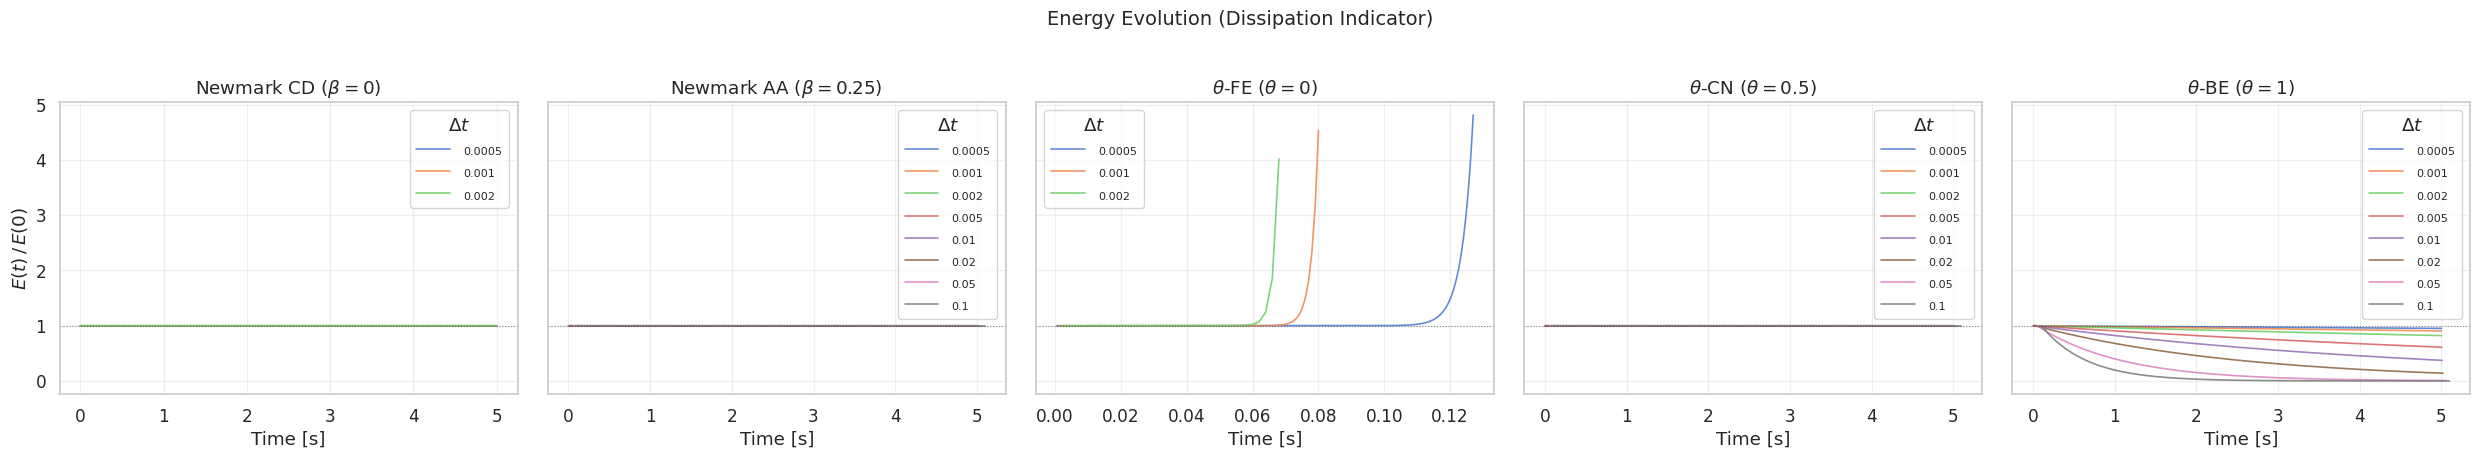

In [12]:
# ================================================================
# Plot: Normalised energy E(t)/E(0) vs time  — one subplot per scheme
# ================================================================

if energy_series:
    schemes_present = sorted(set(k[0] for k in energy_series))
    n_schemes = len(schemes_present)
    fig, axes = plt.subplots(1, n_schemes, figsize=(5 * n_schemes, 4.5), sharey=True)
    if n_schemes == 1:
        axes = [axes]

    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in energy_series if k[0] == scheme], key=lambda x: x[1])

        rows = []
        for key in dt_keys:
            edf = energy_series[key]
            E0 = edf["energy"].iloc[0]
            if E0 > 0:
                ratio = edf["energy"] / E0
                # Truncate at first divergence to avoid y-scale distortion
                exceed = ratio.abs() > ENERGY_CLIP
                if exceed.any():
                    cut = int(exceed.values.argmax())
                    t_vals, r_vals = edf["time"].iloc[:cut].values, ratio.iloc[:cut].values
                else:
                    t_vals, r_vals = edf["time"].values, ratio.values
                rows.append(pd.DataFrame({
                    "Time [s]":  t_vals,
                    "E(t)/E(0)": r_vals,
                    "dt":        f"{key[1]:.4g}",
                }))

        if rows:
            plot_df = pd.concat(rows, ignore_index=True)
            sns.lineplot(
                data=plot_df, x="Time [s]", y="E(t)/E(0)",
                hue="dt", ax=ax, alpha=0.85, linewidth=1.2,
            )
            leg = ax.get_legend()
            if leg is not None:
                leg.set_title(r"$\Delta t$")
                for text in leg.get_texts():
                    text.set_fontsize(8)

        ax.axhline(1.0, color="k", ls=":", lw=0.8, alpha=0.5)
        ax.set_xlabel("Time [s]")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme))

    axes[0].set_ylabel(r"$E(t)\,/\,E(0)$")
    fig.suptitle("Energy Evolution (Dissipation Indicator)", fontsize=14, y=1.02)
    fig.tight_layout()
    fig.savefig(FIG_DIR / "energy_evolution.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "energy_evolution.png", bbox_inches="tight", dpi=150)
    plt.show()
else:
    print("No energy time-series data available. Run the sweep first.")


## 6. Dispersion Analysis — Point Probe vs Exact Solution

The most direct way to *see* dispersion is to overlay the **numerical solution at the domain centre** $(0.5, 0.5)$ with the **exact solution**:

$$u_{\text{exact}}(0.5,\,0.5,\,t) = \cos\!\bigl(\sqrt{2}\,\pi\,t\bigr)$$

since $\sin(\pi/2) = 1$.  A **dispersive** scheme produces a cosine with a slightly wrong frequency $\tilde\omega \neq \omega$, so the two curves gradually **drift out of phase**.  A **dissipative** scheme also shows **amplitude decay** on top of the phase shift.

If no probe data is available yet, we fall back to the $L^2$ error time-series.

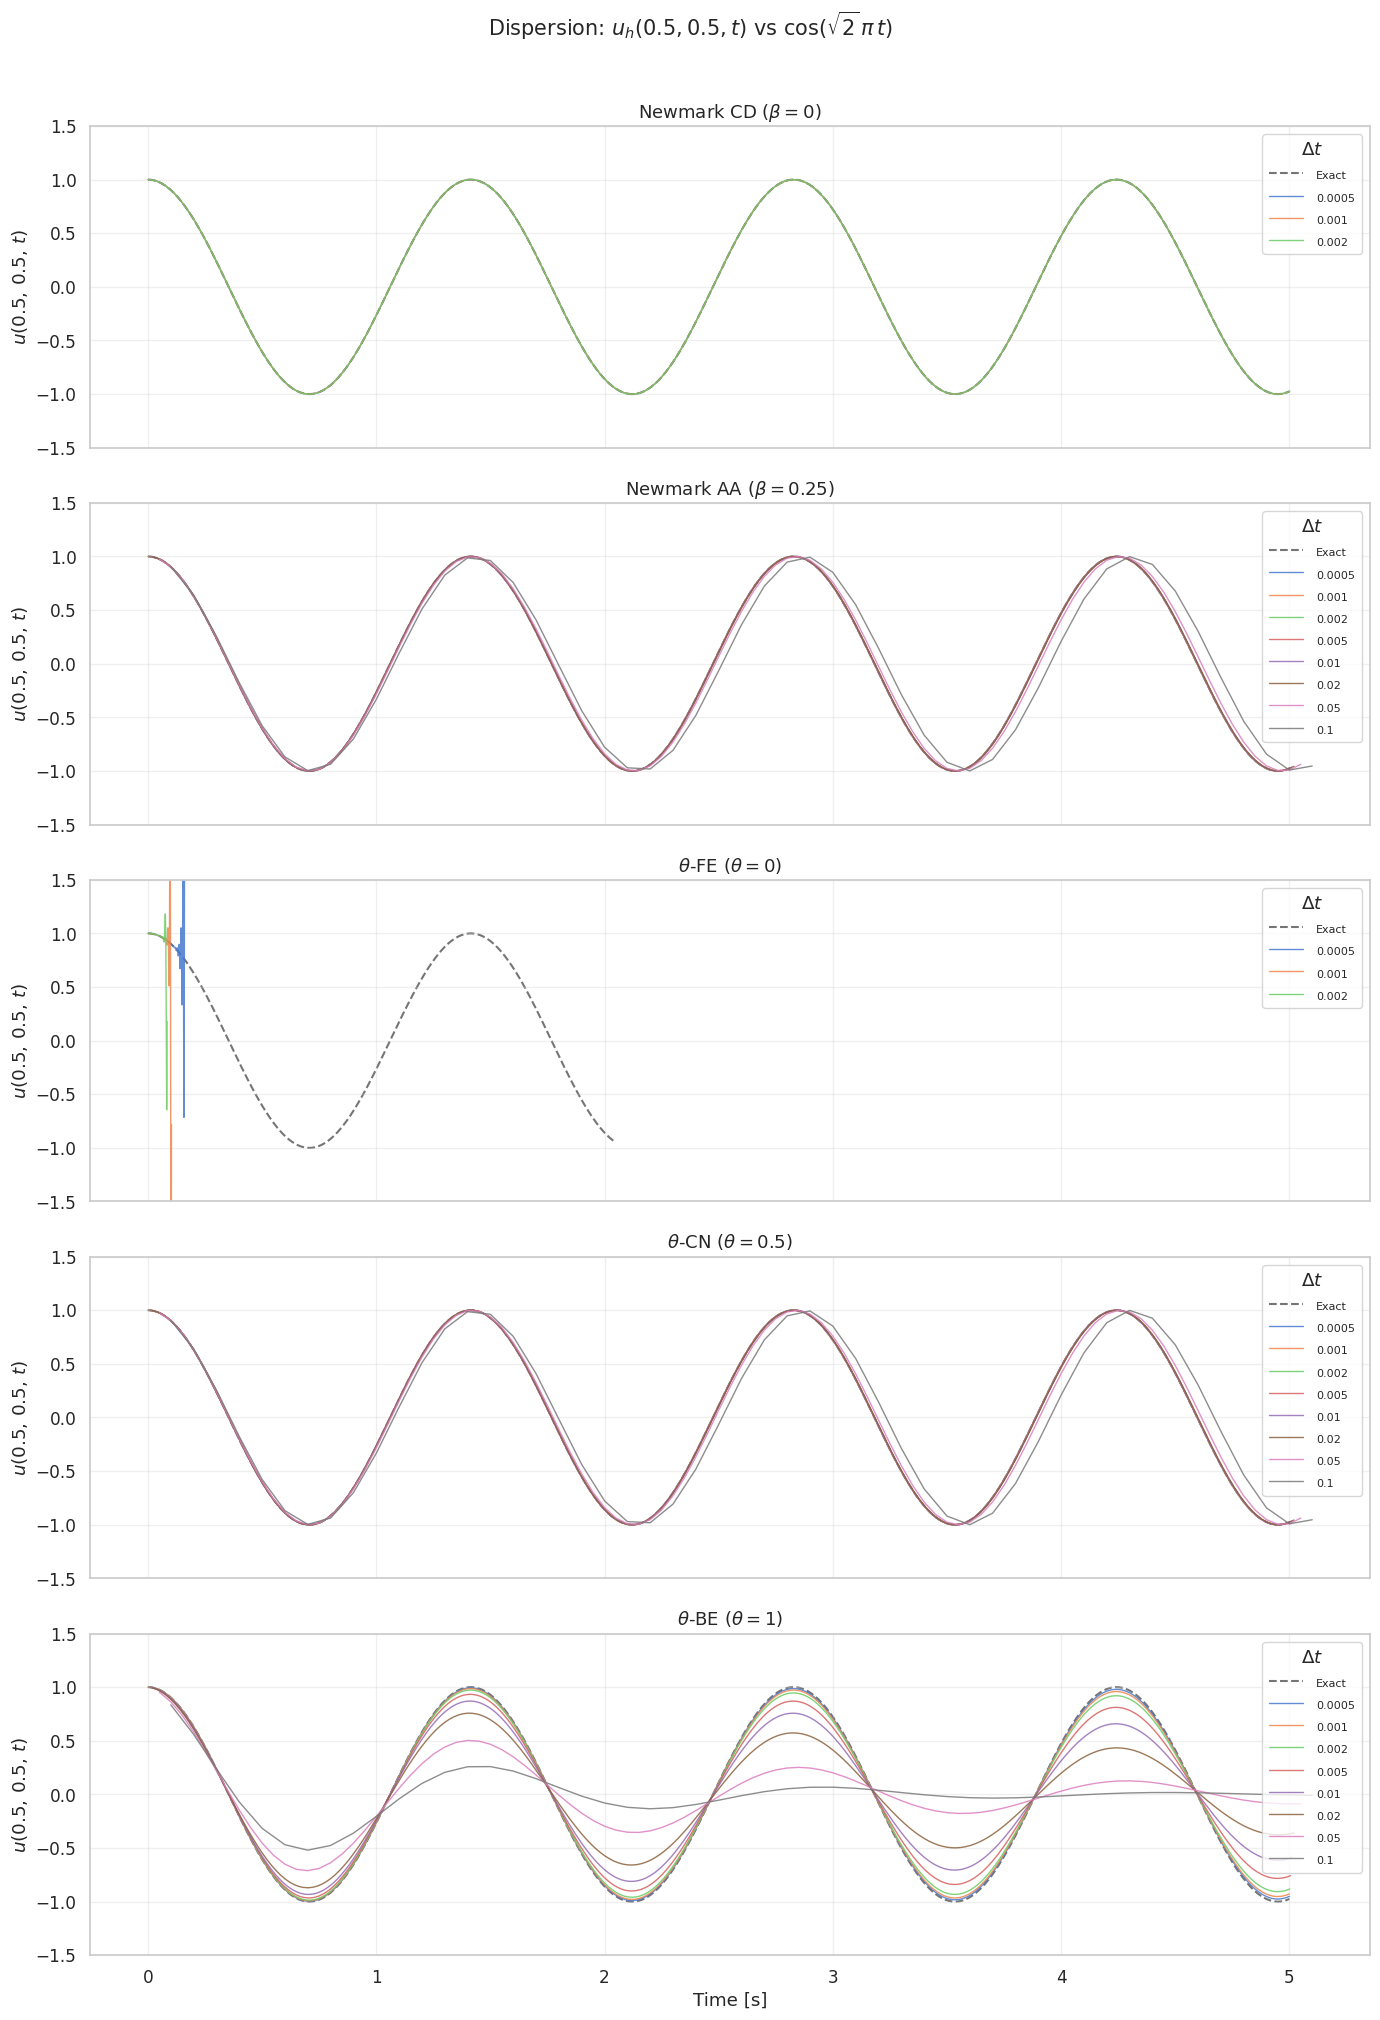

In [13]:
# ================================================================
# Plot: u(0.5, 0.5, t) numerical vs exact — one subplot per scheme
# ================================================================

if probe_series:
    schemes_present = sorted(set(k[0] for k in probe_series))
    n_schemes = len(schemes_present)
    fig, axes = plt.subplots(n_schemes, 1, figsize=(14, 4 * n_schemes), sharex=True)
    if n_schemes == 1:
        axes = [axes]

    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in probe_series if k[0] == scheme], key=lambda x: x[1])

        # Exact solution (never diverges — always plot in full)
        t_fine = np.linspace(0, probe_series[dt_keys[0]]["time"].iloc[-1], 2000)
        u_exact = np.cos(OMEGA_EXACT * t_fine)
        ax.plot(t_fine, u_exact, "k--", lw=1.5, alpha=0.6, label="Exact", zorder=0)

        # Numerical solutions — truncate diverging ones before plotting
        rows = []
        for key in dt_keys:
            pdf = probe_series[key]
            u = pdf["u_probe"]
            exceed = u.abs() > PROBE_CLIP
            if exceed.any():
                cut = int(exceed.values.argmax())
                t_vals = pdf["time"].iloc[:cut].values
                u_vals = u.iloc[:cut].values
            else:
                t_vals = pdf["time"].values
                u_vals = u.values
            rows.append(pd.DataFrame({
                "Time [s]":       t_vals,
                "u(0.5, 0.5, t)": u_vals,
                "dt":             f"{key[1]:.4g}",
            }))

        if rows:
            plot_df = pd.concat(rows, ignore_index=True)
            sns.lineplot(
                data=plot_df, x="Time [s]", y="u(0.5, 0.5, t)",
                hue="dt", ax=ax, alpha=0.85, linewidth=1.0,
            )
            leg = ax.get_legend()
            if leg is not None:
                leg.set_title(r"$\Delta t$")
                for text in leg.get_texts():
                    text.set_fontsize(8)

        ax.set_ylabel(r"$u(0.5,\,0.5,\,t)$")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme), fontsize=13)
        ax.set_ylim(-1.5, 1.5)

    axes[-1].set_xlabel("Time [s]")
    fig.suptitle(r"Dispersion: $u_h(0.5,0.5,t)$ vs $\cos(\sqrt{2}\,\pi\,t)$",
                 fontsize=15, y=1.01)
    fig.tight_layout()
    fig.savefig(FIG_DIR / "probe_vs_exact.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "probe_vs_exact.png", bbox_inches="tight", dpi=150)
    plt.show()

elif error_series:
    # Fallback: show L2 error evolution
    schemes_present = sorted(set(k[0] for k in error_series))
    n_schemes = len(schemes_present)
    fig, axes = plt.subplots(1, n_schemes, figsize=(5 * n_schemes, 4.5), sharey=True)
    if n_schemes == 1:
        axes = [axes]
    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in error_series if k[0] == scheme], key=lambda x: x[1])
        rows = []
        for key in dt_keys:
            edf = error_series[key]
            err = edf["rel_L2_error"]
            # Truncate if error explodes
            exceed = err > 1e3
            if exceed.any():
                cut = int(exceed.values.argmax())
                t_vals, e_vals = edf["time"].iloc[:cut].values, err.iloc[:cut].values
            else:
                t_vals, e_vals = edf["time"].values, err.values
            rows.append(pd.DataFrame({
                "Time [s]":           t_vals,
                "Rel. L2 error":      e_vals,
                "dt":                 f"{key[1]:.4g}",
            }))
        if rows:
            plot_df = pd.concat(rows, ignore_index=True)
            sns.lineplot(data=plot_df, x="Time [s]", y="Rel. L2 error",
                         hue="dt", ax=ax, alpha=0.8, linewidth=1.0)
            leg = ax.get_legend()
            if leg is not None:
                leg.set_title(r"$\Delta t$")
                for text in leg.get_texts():
                    text.set_fontsize(7)
        ax.set_xlabel("Time [s]")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme))
        ax.set_yscale("log")
    axes[0].set_ylabel(r"Relative $L^2$ error")
    fig.suptitle(r"$L^2$ Error Evolution (no probe data yet — run sweep after rebuild)",
                 fontsize=14, y=1.02)
    fig.tight_layout()
    plt.show()
else:
    print("No probe or error time-series data available.")


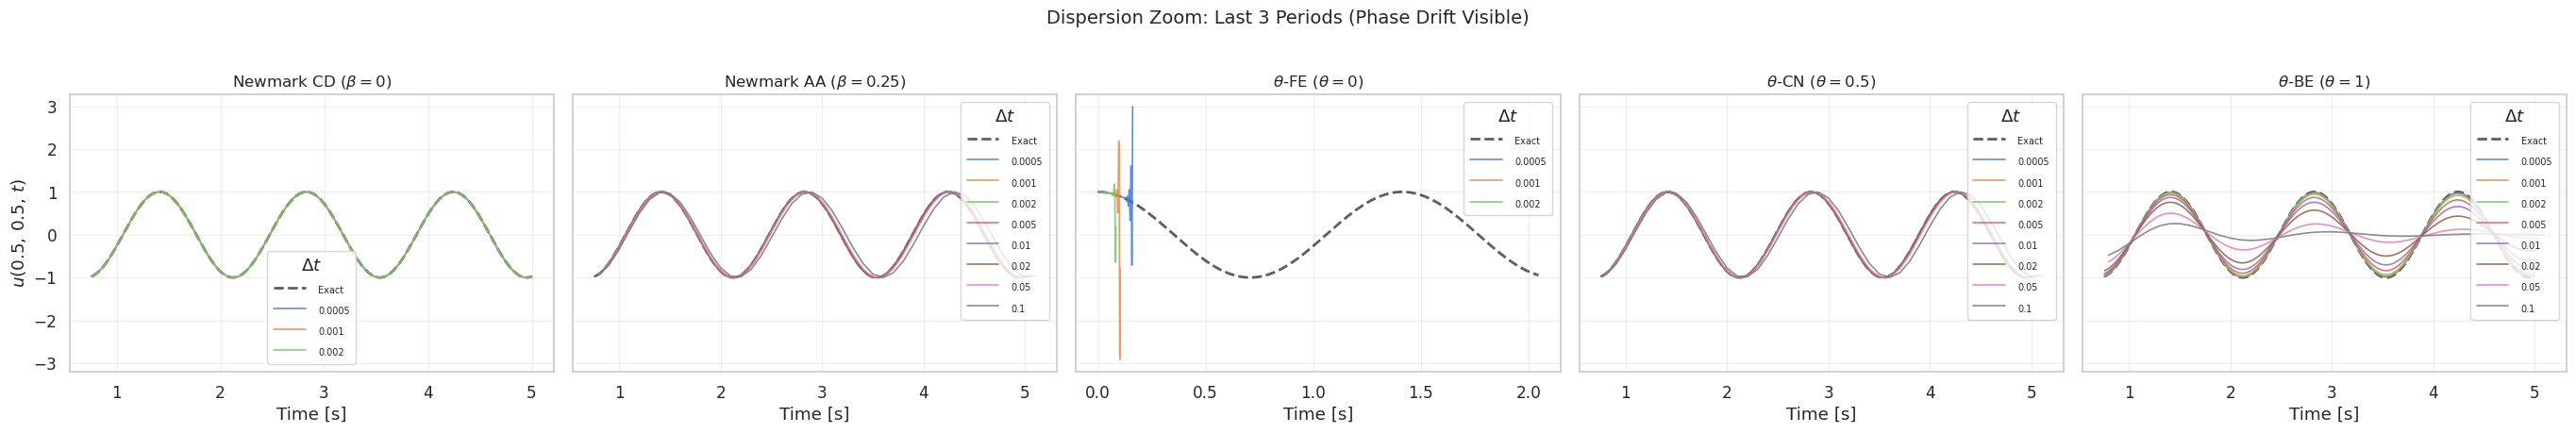

In [14]:
# ================================================================
# Zoomed view: last few periods — phase drift is most visible here
# ================================================================

if probe_series:
    schemes_present = sorted(set(k[0] for k in probe_series))
    n_schemes = len(schemes_present)

    # Exact period = 2*pi / omega = 2*pi / (sqrt(2)*pi) = sqrt(2) ≈ 1.414 s
    T_period = 2.0 * np.pi / OMEGA_EXACT

    fig, axes = plt.subplots(1, n_schemes, figsize=(5.5 * n_schemes, 4.5), sharey=True)
    if n_schemes == 1:
        axes = [axes]

    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in probe_series if k[0] == scheme], key=lambda x: x[1])
        T_end = probe_series[dt_keys[0]]["time"].iloc[-1]
        t_start = max(0.0, T_end - 3.0 * T_period)

        # Exact solution over the zoom window
        t_fine = np.linspace(t_start, T_end, 2000)
        u_exact = np.cos(OMEGA_EXACT * t_fine)
        ax.plot(t_fine, u_exact, "k--", lw=2.0, alpha=0.7, label="Exact")

        # Numerical solutions — truncate diverging ones, then zoom
        rows = []
        for key in dt_keys:
            pdf = probe_series[key]
            u = pdf["u_probe"]
            # Step 1: truncate at divergence
            exceed = u.abs() > PROBE_CLIP
            if exceed.any():
                cut = int(exceed.values.argmax())
                pdf_clean = pdf.iloc[:cut]
            else:
                pdf_clean = pdf
            # Step 2: zoom to last 3 periods
            mask = pdf_clean["time"] >= t_start
            t_vals = pdf_clean.loc[mask, "time"].values
            u_vals = pdf_clean.loc[mask, "u_probe"].values
            if len(t_vals) > 0:
                rows.append(pd.DataFrame({
                    "Time [s]":       t_vals,
                    "u(0.5, 0.5, t)": u_vals,
                    "dt":             f"{key[1]:.4g}",
                }))

        if rows:
            plot_df = pd.concat(rows, ignore_index=True)
            sns.lineplot(
                data=plot_df, x="Time [s]", y="u(0.5, 0.5, t)",
                hue="dt", ax=ax, alpha=0.85, linewidth=1.2,
            )
            leg = ax.get_legend()
            if leg is not None:
                leg.set_title(r"$\Delta t$")
                for text in leg.get_texts():
                    text.set_fontsize(7)

        ax.set_xlabel("Time [s]")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme), fontsize=12)

    axes[0].set_ylabel(r"$u(0.5,\,0.5,\,t)$")
    fig.suptitle("Dispersion Zoom: Last 3 Periods (Phase Drift Visible)", fontsize=14, y=1.02)
    fig.tight_layout()
    fig.savefig(FIG_DIR / "probe_zoom_last_periods.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "probe_zoom_last_periods.png", bbox_inches="tight", dpi=150)
    plt.show()

else:
    # Fallback: error vs dt (summary)
    if not df.empty and "final_rel_L2" in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
        ax = axes[0]
        for scheme in df["scheme"].unique():
            sub = df[df["scheme"] == scheme].dropna(subset=["max_rel_L2"]).sort_values("dt")
            if sub.empty:
                continue
            sns.lineplot(
                data=sub, x="dt", y="max_rel_L2",
                marker=SCHEME_MARKERS.get(scheme, "o"),
                color=SCHEME_COLORS.get(scheme, "gray"),
                label=SCHEME_LABELS.get(scheme, scheme),
                linewidth=1.5, markersize=7, ax=ax,
            )
        dt_ref = np.array([1e-3, 1e-1])
        ax.loglog(dt_ref, 2 * dt_ref**1, "k:", alpha=0.3, label=r"$O(\Delta t)$")
        ax.loglog(dt_ref, 2 * dt_ref**2, "k--", alpha=0.3, label=r"$O(\Delta t^2)$")
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_xlabel(r"$\Delta t$"); ax.set_ylabel(r"Max rel. $L^2$ error")
        ax.set_title(r"Max $L^2$ Error vs $\Delta t$"); ax.legend(fontsize=9)

        ax = axes[1]
        for scheme in df["scheme"].unique():
            sub = df[df["scheme"] == scheme].dropna(subset=["final_rel_L2"]).sort_values("dt")
            if sub.empty:
                continue
            sns.lineplot(
                data=sub, x="dt", y="final_rel_L2",
                marker=SCHEME_MARKERS.get(scheme, "o"),
                color=SCHEME_COLORS.get(scheme, "gray"),
                label=SCHEME_LABELS.get(scheme, scheme),
                linewidth=1.5, markersize=7, ax=ax,
            )
        ax.loglog(dt_ref, 2 * dt_ref**1, "k:", alpha=0.3, label=r"$O(\Delta t)$")
        ax.loglog(dt_ref, 2 * dt_ref**2, "k--", alpha=0.3, label=r"$O(\Delta t^2)$")
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_xlabel(r"$\Delta t$"); ax.set_ylabel(r"Final rel. $L^2$ error")
        ax.set_title(r"Final-Time $L^2$ Error vs $\Delta t$"); ax.legend(fontsize=9)
        fig.tight_layout()
        plt.show()
    else:
        print("No data available.")


## 8. Side-by-Side: Dissipation (Energy) + Dispersion (Probe)

One figure per scheme showing **energy** $E(t)/E(0)$ on the left and **probe** $u_h(0.5,0.5,t)$ on the right, for a single representative $\Delta t$.  This gives the clearest visual of how each scheme behaves.

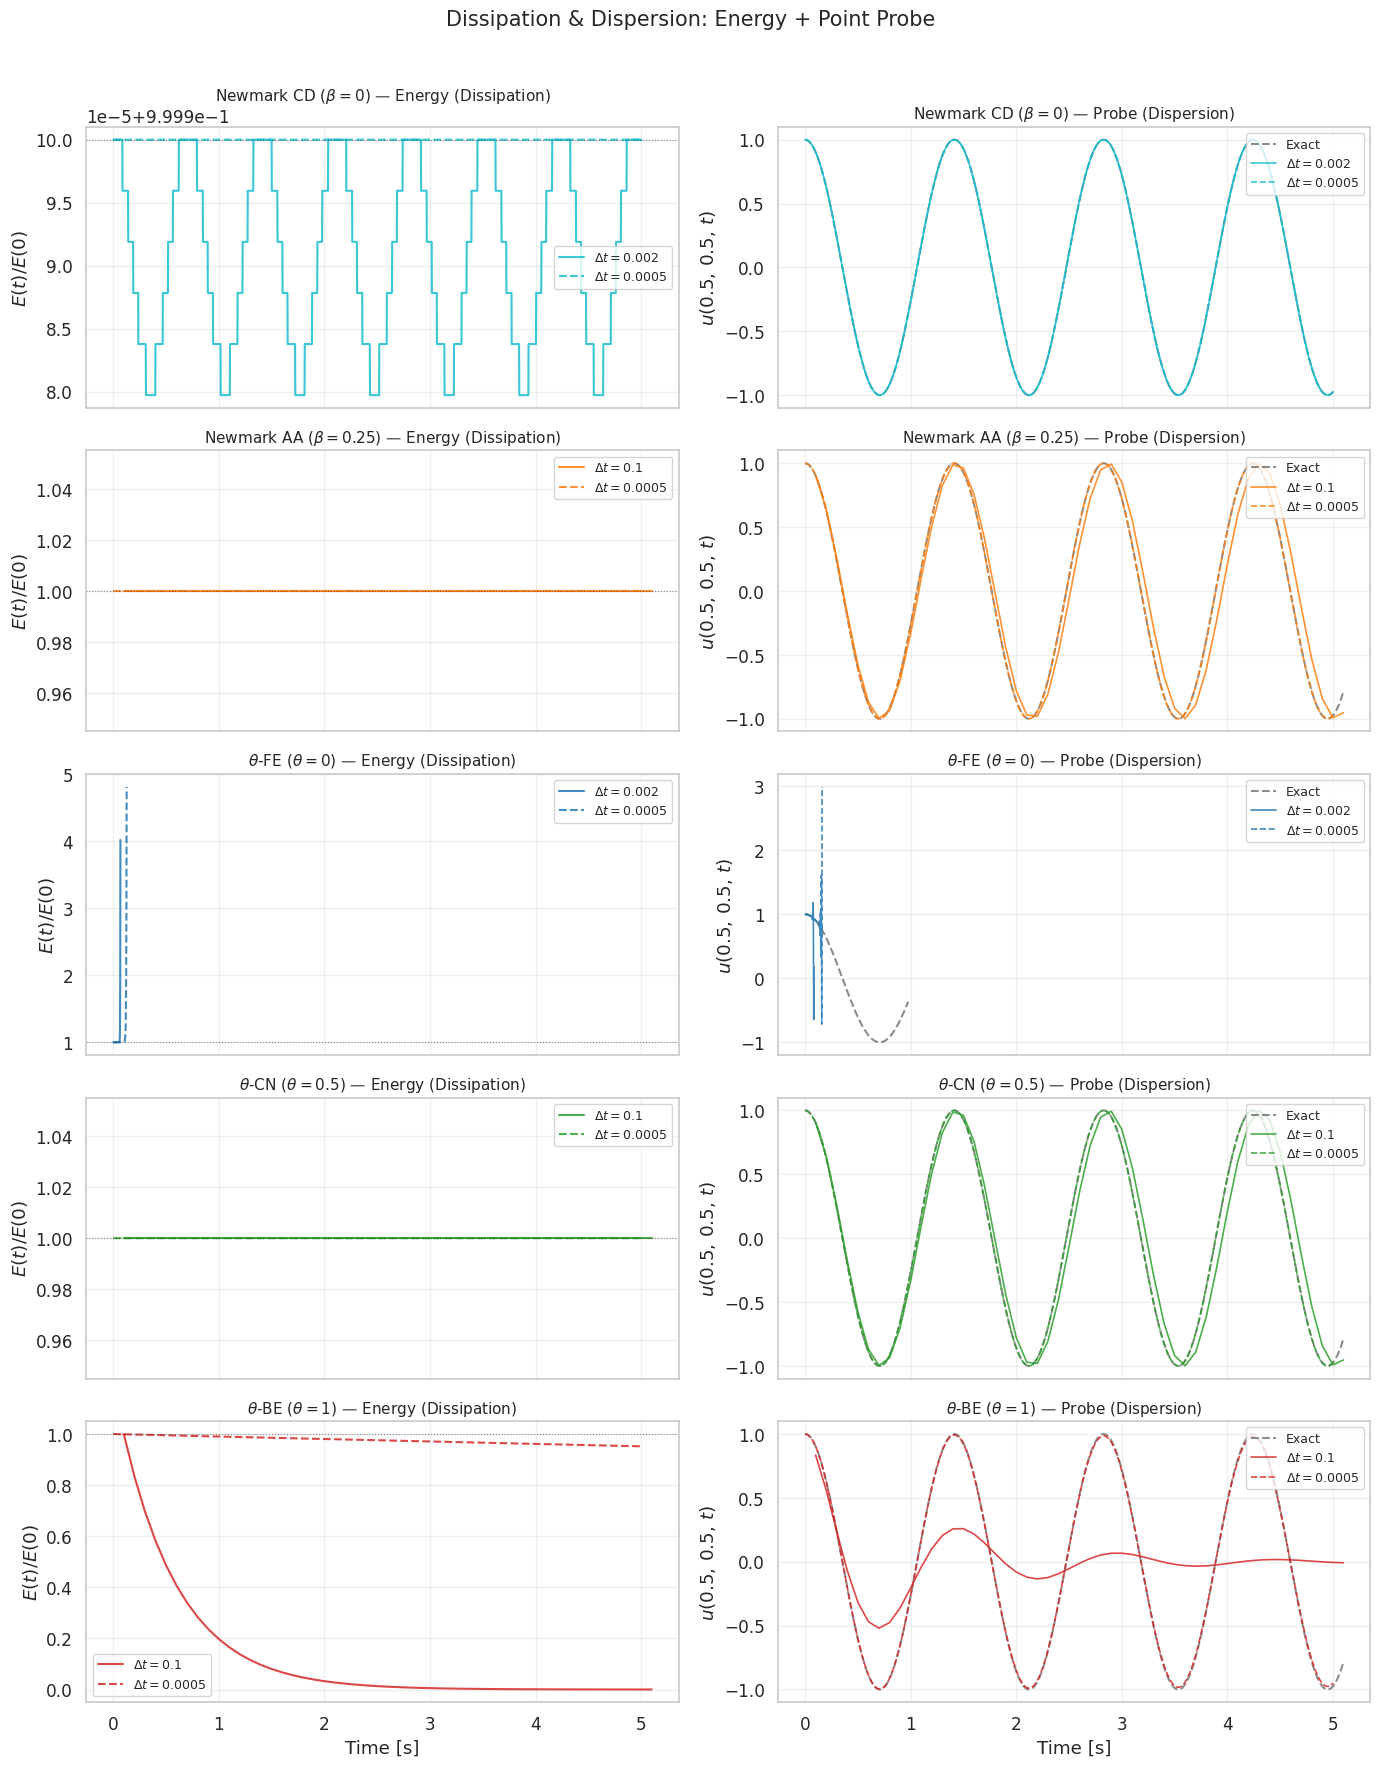

In [15]:
# ================================================================
# Side-by-side: Energy + Probe for a representative dt per scheme
# ================================================================

if probe_series and energy_series:
    # Pick the largest and smallest dt available for each scheme (most / least visible effects)
    schemes_present = sorted(set(k[0] for k in probe_series))

    fig, axes = plt.subplots(len(schemes_present), 2,
                             figsize=(14, 3.5 * len(schemes_present)),
                             sharex="col")
    if len(schemes_present) == 1:
        axes = axes[np.newaxis, :]

    for i, scheme in enumerate(schemes_present):
        # Find dt values available in both energy and probe
        common_dts = sorted(
            set(k[1] for k in probe_series if k[0] == scheme) &
            set(k[1] for k in energy_series if k[0] == scheme),
            reverse=True
        )
        dts_to_show = []
        if len(common_dts) >= 2:
            dts_to_show = [common_dts[0], common_dts[-1]]   # largest, smallest
        elif common_dts:
            dts_to_show = [common_dts[0]]

        scheme_color = SCHEME_COLORS.get(scheme, "gray")
        linestyles = ["-", "--"]

        # ── Energy panel ──────────────────────────────────────────
        ax_e = axes[i, 0]
        for j, dt_val in enumerate(dts_to_show):
            edf = energy_series[(scheme, dt_val)]
            E0  = edf["energy"].iloc[0]
            ratio = edf["energy"] / E0
            # Truncate at divergence
            exceed = ratio.abs() > ENERGY_CLIP
            if exceed.any():
                cut = int(exceed.values.argmax())
                t_vals, r_vals = edf["time"].iloc[:cut].values, ratio.iloc[:cut].values
            else:
                t_vals, r_vals = edf["time"].values, ratio.values
            sns.lineplot(
                x=t_vals, y=r_vals,
                ax=ax_e, color=scheme_color, linestyle=linestyles[j],
                alpha=0.85, linewidth=1.5, label=rf"$\Delta t = {dt_val:.4g}$",
            )
        ax_e.axhline(1.0, color="k", ls=":", lw=0.8, alpha=0.5)
        ax_e.set_ylabel(r"$E(t)/E(0)$")
        ax_e.set_title(f"{SCHEME_LABELS.get(scheme, scheme)} — Energy (Dissipation)", fontsize=11)
        ax_e.legend(fontsize=9)

        # ── Probe panel ───────────────────────────────────────────
        ax_p = axes[i, 1]
        T_end  = probe_series[(scheme, dts_to_show[0])]["time"].iloc[-1]
        t_fine = np.linspace(0, T_end, 3000)
        ax_p.plot(t_fine, np.cos(OMEGA_EXACT * t_fine),
                  "k--", lw=1.5, alpha=0.5, label="Exact")

        for j, dt_val in enumerate(dts_to_show):
            pdf = probe_series[(scheme, dt_val)]
            u   = pdf["u_probe"]
            # Truncate at divergence
            exceed = u.abs() > PROBE_CLIP
            if exceed.any():
                cut = int(exceed.values.argmax())
                t_vals, u_vals = pdf["time"].iloc[:cut].values, u.iloc[:cut].values
            else:
                t_vals, u_vals = pdf["time"].values, u.values
            sns.lineplot(
                x=t_vals, y=u_vals,
                ax=ax_p, color=scheme_color, linestyle=linestyles[j],
                alpha=0.85, linewidth=1.2, label=rf"$\Delta t = {dt_val:.4g}$",
            )
        ax_p.set_ylabel(r"$u(0.5,\,0.5,\,t)$")
        ax_p.set_title(f"{SCHEME_LABELS.get(scheme, scheme)} — Probe (Dispersion)", fontsize=11)
        ax_p.legend(fontsize=9, loc="upper right")

    axes[-1, 0].set_xlabel("Time [s]")
    axes[-1, 1].set_xlabel("Time [s]")
    fig.suptitle("Dissipation & Dispersion: Energy + Point Probe", fontsize=15, y=1.01)
    fig.tight_layout()
    fig.savefig(FIG_DIR / "side_by_side_energy_probe.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "side_by_side_energy_probe.png", bbox_inches="tight", dpi=150)
    plt.show()
else:
    print("Need both energy and probe data. Run the sweep after rebuilding.")


## 9. Summary Table

A concise comparison table of all schemes and their dissipation/dispersion properties.

In [16]:
# ================================================================
# Summary comparison table
# ================================================================

summary_data = {
    "Scheme": [
        r"θ-FE (θ=0)",
        r"θ-CN (θ=0.5)",
        r"θ-BE (θ=1)",
        r"Newmark CD (β=0)",
        r"Newmark AA (β=0.25)",
    ],
    "Stability": [
        "Conditional (Ω < 1)",
        "Unconditional",
        "Unconditional",
        "Conditional (Ω < 2)",
        "Unconditional",
    ],
    "Dissipation (Energy)": [
        "E grows (|g|>1, unstable)",
        "E conserved (|g|=1)",
        "E decays (|g|<1)",
        "E grows if Ω>2",
        "E conserved (|g|=1)",
    ],
    "Dispersion (Probe)": [
        "Phase lag, O(Δt²)",
        "Phase lag, O(Δt²)",
        "Phase lag, O(Δt²)",
        "Phase lag, O(Δt²)",
        "Phase lag, O(Δt²)",
    ],
    "Temporal Accuracy": [
        "1st order",
        "2nd order",
        "1st order",
        "2nd order",
        "2nd order",
    ],
}

df_summary = pd.DataFrame(summary_data)

try:
    styled = df_summary.style.set_properties(**{
        'text-align': 'center',
        'border': '1px solid #ccc',
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
    ]).hide(axis="index")
    display(styled)
except Exception:
    print(df_summary.to_string(index=False))

print("\nKey observations:")
print("  • Dissipation → look at E(t)/E(0): CN and Newmark AA conserve energy exactly.")
print("  • Dispersion  → look at u_h(0.5,0.5,t) vs cos(√2·π·t): phase drift visible for large Δt.")
print("  • BE (θ=1) shows BOTH amplitude decay AND phase shift.")
print("  • CN and Newmark AA are the best: energy-conserving + 2nd-order accurate.")
print("  • FE (θ=0) and CD (β=0) are conditionally stable — CFL restriction required.")

Scheme,Stability,Dissipation (Energy),Dispersion (Probe),Temporal Accuracy
θ-FE (θ=0),Conditional (Ω < 1),"E grows (|g|>1, unstable)","Phase lag, O(Δt²)",1st order
θ-CN (θ=0.5),Unconditional,E conserved (|g|=1),"Phase lag, O(Δt²)",2nd order
θ-BE (θ=1),Unconditional,E decays (|g|<1),"Phase lag, O(Δt²)",1st order
Newmark CD (β=0),Conditional (Ω < 2),E grows if Ω>2,"Phase lag, O(Δt²)",2nd order
Newmark AA (β=0.25),Unconditional,E conserved (|g|=1),"Phase lag, O(Δt²)",2nd order



Key observations:
  • Dissipation → look at E(t)/E(0): CN and Newmark AA conserve energy exactly.
  • Dispersion  → look at u_h(0.5,0.5,t) vs cos(√2·π·t): phase drift visible for large Δt.
  • BE (θ=1) shows BOTH amplitude decay AND phase shift.
  • CN and Newmark AA are the best: energy-conserving + 2nd-order accurate.
  • FE (θ=0) and CD (β=0) are conditionally stable — CFL restriction required.
